In [1]:
# from patch_CAVI import *
import numpy as np
import matplotlib.pyplot as plt
import torch
from types import SimpleNamespace
import sys
sys.path.append('..')
from field_of_junctions import FieldOfJunctions
import matplotlib
import cv2
# from patch_CAVI_unary import *
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

## Helper functions and MRF permutation resolver

In [2]:
def reconstruct_img(out,H,W,stride,PSZ):
    rec = np.zeros([H,W,int(out.shape[-2]*out.shape[-1])])
    num_overlaps = np.zeros([H,W])
    itr = 0
    for i in range(out.shape[-2]):
        for j in range(out.shape[-1]):
            rec[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ,itr] = out[...,i,j].detach().cpu().numpy()
            num_overlaps[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ] += 1
            itr = itr+1
    return np.divide(np.sum(rec,axis = -1),num_overlaps)


#Code from DOR's CAVI implementation (changes in all caps)

def get_permutations(region_patches):
    """
    region_patches is [1, 1, 3, 1, RF, RF, H_patches, W_patches
    """
    return region_patches[0, 0, perm_list.permute(1, 0), 0, :, :, :, :]  # [3, 6, RF, RF, H_patches, W_patches]

def local_resolve_permutations_mrf(permutations, stride, neighborhood=4, unary = None, unary_func = None, max_iters=None, func=None, func2=None, seed=None):
    """
    #region_patches has shape [1, 1, 3, 1, RF, RF, H_patches, W_patches]
    permutations has shape [3, 6, RF, RF, H_patches, W_patches]
    """

    assert neighborhood in [4, 8], "neighborhood must be 4 or 8"

    H_patches = permutations.shape[-2]
    W_patches = permutations.shape[-1]

    RF = permutations.shape[-3]
    assert permutations.shape[-4] == RF, "RF must be square"

    if func is None:
        func = lambda x: 10.0 * torch.exp(-100.0 * x)

    if func2 is None:
        func2 = lambda x: 10.0 * torch.exp(-100.0 * x)

    if max_iters is None:
        max_iters = 2 * max([W_patches, H_patches])

    # Create a 6x6xHx(W-1) array of log pairwise potentials for horizontal edges
    # and a 6x6x(H-1)xW array for vertical ones.

    # horizontal_logpsi[k, l, i, j] is the log psi function between the (i, j) and (i, j+1) patches evaluated at
    # the kth and lth permutation respectively.
    horizontal_logpsi = func((permutations[:, :, :, stride:, :, :-1].unsqueeze(2) -
                              permutations[:, :, :, :-stride, :, 1:].unsqueeze(1)).abs().sum(0).mean(2).mean(2))

    # vertical_logpsi[k, l, i, j] is the log psi function between the (i, j) and (i+1, j) patches evaluated at
    # the kth and lth permutation respectively.
    vertical_logpsi = func((permutations[:, :, stride:, :, :-1, :].unsqueeze(2) -
                            permutations[:, :, :-stride, :, 1:, :].unsqueeze(1)).abs().sum(0).mean(2).mean(2))

    # Add padding to avoid having to deal with image boundaries
    horizontal_logpsi = torch.nn.functional.pad(horizontal_logpsi, pad=(1, 1, 1, 1))
    vertical_logpsi = torch.nn.functional.pad(vertical_logpsi, pad=(1, 1, 1, 1))

    if neighborhood == 8:
        # angle45_logpsi[k, l, i, j] is the log psi function between the (i, j) and (i+1, j+1) patches evaluated at
        # the kth and lth permutations respectively.
        angle45_logpsi = func2((permutations[:, :, stride:, stride:, :-1, :-1].unsqueeze(2) -
                                permutations[:, :, :-stride, :-stride, 1:, 1:].unsqueeze(1)).abs().sum(0).mean(2).mean(
            2))

        # angle135_logpsi[k, l, i, j] is the log psi function between the (i, j+1) and (i+1, j) patches evaluated at
        # the kth and lth permutations respectively. [Note: This is a shifted version of the match between (i, j) and (i+1, j-1).]
        angle135_logpsi = func2((permutations[:, :, stride:, :-stride, :-1, 1:].unsqueeze(2) -
                                 permutations[:, :, :-stride, stride:, 1:, :-1].unsqueeze(1)).abs().sum(0).mean(2).mean(
            2))

        # Add padding to avoid having to deal with image boundaries
        angle45_logpsi = torch.nn.functional.pad(angle45_logpsi, pad=(1, 1, 1, 1))
        angle135_logpsi = torch.nn.functional.pad(angle135_logpsi, pad=(1, 1, 1, 1))

    # Set all distributions to uniform except seed which is set to [1, 0, 0, 0, 0, 0].
    lmbdas = torch.ones((6, H_patches + 2, W_patches + 2), dtype=torch.float32).to(permutations.device) / 6.0

    # Unless specified, set seed to the non-constant patch closest to center
    if seed is None:
        # Find patches with at least 2 colors (i.e. no uniform region)
        good_patches = permutations[:, 0, :, :, :, :].max(dim=-3)[0].max(dim=-3)[0].sum(0) > 1.5

        # Find closest such patch to the center
        good_patch_inds = good_patches.nonzero()
        if len(good_patch_inds.shape) < 2:
            seed = (H_patches // 2, W_patches // 2)
        else:
            gpiy = good_patch_inds[:, 0] - (H_patches - 1) / 2.0
            gpix = good_patch_inds[:, 1] - (W_patches - 1) / 2.0
            ind = torch.argmin(gpix ** 2 + gpiy ** 2)

            seed = good_patch_inds[ind, :]

#     lmbdas[0, seed[0] + 1, seed[1] + 1] = 1.0
#     lmbdas[1:, seed[0] + 1, seed[1] + 1] = 0.0
    for t in range(max_iters):
        #ADDED UNARY TERM UPDATES
        if unary is not None:
            t1 = lmbdas[:, 1:-1, 1:-1] == torch.max(lmbdas[:, 1:-1, 1:-1],0)[0].unsqueeze(0).repeat(6,1,1)
            t2 = unary == torch.max(unary,0)[0].unsqueeze(0).repeat(6,1,1)
            #Logical intersect tells if argmax of q_j and the potential at j are equal
            #Second term exculdes suprious equalities (when many of the q_j are the same (happens a lot at init))
            logical_intersect = torch.max(t1*t2,0)[0] *(t1.sum(dim=0)>1)
#             lmbdas[:, 1:-1, 1:-1] += unary * ((max_iters-t)/max_iters) #Product term to reduce strength of prior over time
            lmbdas[:, 1:-1, 1:-1] += unary * unary_func(max_iters,t) * ~logical_intersect
            lmbdas /= lmbdas.sum(dim=0, keepdim=True)
        # Left neighbor:   sum over permutations of the (i, j-1)th patch, i.e. dimension 0
        s = (lmbdas.unsqueeze(1)[:, :, 1:-1, :-2] * horizontal_logpsi[:, :, 1:-1, :-1]).sum(dim=0)
        # Right neighbor:  sum over permutations of the (i, j+1)th patch, i.e. dimension 1
        s += (lmbdas.unsqueeze(0)[:, :, 1:-1, 2:] * horizontal_logpsi[:, :, 1:-1, 1:]).sum(dim=1)
        # Top neighbor:    sum over permutations of the (i-1, j)th patch, i.e. dimension 0
        s += (lmbdas.unsqueeze(1)[:, :, :-2, 1:-1] * vertical_logpsi[:, :, :-1, 1:-1]).sum(dim=0)
        # Bottom neighbor: sum over permutations of the (i+1, j)th patch, i.e. dimension 1
        s += (lmbdas.unsqueeze(0)[:, :, 2:, 1:-1] * vertical_logpsi[:, :, 1:, 1:-1]).sum(dim=1)

        if neighborhood == 8:
            # TL neighbor: sum over permutations of the (i-1, j-1)th patch, i.e. dimension 0
            s += (lmbdas.unsqueeze(1)[:, :, :-2, :-2] * angle45_logpsi[:, :, :-1, :-1]).sum(dim=0)
            # BR neighbor: sum over permutations of the (i+1, j+1)th patch, i.e. dimension 1
            s += (lmbdas.unsqueeze(0)[:, :, 2:, 2:] * angle45_logpsi[:, :, 1:, 1:]).sum(dim=1)
            # TR neighbor: sum over permutations of the (i-1, j+1)th patch, i.e. dimension 0
            s += (lmbdas.unsqueeze(1)[:, :, :-2, 2:] * angle135_logpsi[:, :, :-1, 1:]).sum(dim=0)
            # BL neighbor: sum over permutations of the (i+1, j-1)th patch, i.e. dimension 1
            s += (lmbdas.unsqueeze(0)[:, :, 2:, :-2] * angle135_logpsi[:, :, 1:, :-1]).sum(dim=1)

        # Update parameters according to CAVI update
        lmbdas[:, 1:-1, 1:-1] = torch.exp(s)


        # Normalize and reset top-left distribution

        lmbdas /= lmbdas.sum(dim=0, keepdim=True)


#         lmbdas[0, seed[0] + 1, seed[1] + 1] = 1.0
#         lmbdas[1:, seed[0] + 1, seed[1] + 1] = 0.0

    lmbdas = lmbdas[:, 1:-1, 1:-1]

    indices = lmbdas.argmax(0)  # shape [H_patches, W_patches]

    return indices

def expanded_resolve_permutations_mrf(permutations, stride, Ns, PLOT=False, unary = None, unary_func = None, max_iters=None, func=None, func2=None, seed=None):
    """
    #region_patches has shape [1, 1, 3, 1, RF, RF, H_patches, W_patches]
    permutations has shape [3, 6, RF, RF, H_patches, W_patches]
    """

    H_patches = permutations.shape[-2]
    W_patches = permutations.shape[-1]

    RF = permutations.shape[-3]
    assert permutations.shape[-4] == RF, "RF must be square"

    if func is None:
        func = lambda x: 10.0 * torch.exp(-100.0 * x)

    if func2 is None:
        func2 = lambda x: 10.0 * torch.exp(-100.0 * x)

    if max_iters is None:
        max_iters = 2 * max([W_patches, H_patches])

    N_list = np.arange(-Ns,Ns+1)

    # Set all distributions to uniform except seed which is set to [1, 0, 0, 0, 0, 0].
    lmbdas = torch.ones((6, H_patches, W_patches), dtype=torch.float32).to(permutations.device) / 6.0
    
    #Create log_psi_mat
    log_psi_mat = torch.zeros(6,6,H_patches,W_patches,Ns*2+1,Ns*2+1)
    for i, hs in enumerate(N_list):
        for j, vs in enumerate(N_list):
            if [hs,vs] != [0,0]:
                padarr = [0,0,0,0]
                #This can be simplified somehow for sure 
                if hs>0:
                    Px = permutations[:,:,hs*stride:,:,:-hs,:]
                    shift_Px = permutations[:,:,:-hs*stride,:,hs:,:]
                    padarr[3] = hs
                elif hs == 0:
                    Px = permutations
                    shift_Px = permutations
                    padarr[3] = hs
                else:
                    Px = permutations[:,:,:hs*stride,:,-hs:,:] 
                    shift_Px = permutations[:,:,-hs*stride:,:,:hs,:]
                    padarr[2] = -hs
                if vs>0: 
                    Py = Px[:,:,:,vs*stride:,:,:-vs]
                    shift_Py = shift_Px[:,:,:,:-vs*stride,:,vs:]
                    padarr[1] = vs
                elif vs == 0: 
                    Py = Px
                    shift_Py = shift_Px
                    padarr[1] = vs
                else:
                    Py = Px[:,:,:,:vs*stride,:,-vs:] 
                    shift_Py = shift_Px[:,:,:,-vs*stride:,:,:vs]
                    padarr[0] = -vs

                t1 = func((shift_Py.unsqueeze(2)-Py.unsqueeze(1)).abs().sum(0).mean(2).mean(2));

                log_psi_mat[...,i,j] = F.pad(t1,padarr)
            
    # Unless specified, set seed to the non-constant patch closest to center
#     lmbdas[0, seed[0] + 1, seed[1] + 1] = 1.0
#     lmbdas[1:, seed[0] + 1, seed[1] + 1] = 0.0

    ind_list = []
    for t in range(max_iters):

        #ADDED UNARY TERM UPDATES
        if unary is not None:
            t1 = lmbdas == torch.max(lmbdas,0)[0].unsqueeze(0).repeat(6,1,1)
            t2 = unary == torch.max(unary,0)[0].unsqueeze(0).repeat(6,1,1)
            #Logical intersect tells if argmax of q_j and the potential at j are equal
            #Second term exculdes suprious equalities (when many of the q_j are the same (happens a lot at init))
            logical_intersect = torch.max(t1*t2,0)[0] *(t1.sum(dim=0)>1)
#             lmbdas[:, 1:-1, 1:-1] += unary * ((max_iters-t)/max_iters) #Product term to reduce strength of prior over time
            lmbdas += unary * unary_func(max_iters,t) * ~logical_intersect
            lmbdas /= lmbdas.sum(dim=0, keepdim=True)
        
        lmbdas_mat = expand_lmbdas(lmbdas,Ns)
#         print(lmbdas.shape,lmbdas_mat.shape,log_psi_mat.shape)
        #Calculate s and exponentiate
        s = (log_psi_mat*lmbdas_mat).sum(1).sum(3).sum(3)

        # Update parameters according to CAVI update
        lmbdas = torch.exp(s)


        # Normalize and reset top-left distribution

        lmbdas /= lmbdas.sum(dim=0, keepdim=True)


#         lmbdas[0, seed[0] + 1, seed[1] + 1] = 1.0
#         lmbdas[1:, seed[0] + 1, seed[1] + 1] = 0.0
        if PLOT:
            indices = lmbdas.argmax(0)  # shape [H_patches, W_patches]
            ind_list.append(indices.detach()) 

    lmbdas = lmbdas
    
    
    indices = lmbdas.argmax(0)  # shape [H_patches, W_patches]
    if PLOT:
        return indices,ind_list
    return indices

# lmbdas = torch.ones((6, H_patches, W_patches), dtype=torch.float32) / 6.0

def expand_lmbdas(lmbdas,Ns):
    lmbdas_mat = torch.zeros(6,H_patches, W_patches,Ns*2+1,Ns*2+1)
    N_list = np.arange(-Ns,Ns+1)
    for i, hs in enumerate(N_list):
        for j, vs in enumerate(N_list):
            if [hs,vs] is not [0,0]:
                padarr = [0,0,0,0]
                #This can be simplified somehow for sure 
                if hs>0:
                    lmbdasx = lmbdas[:,hs:,:]
                    padarr[3] = hs
                elif hs == 0:
                    lmbdasx = lmbdas
                else:
                    lmbdasx = lmbdas[:,:hs,:] 
                    padarr[2] = -hs
                if vs>0: 
                    lmbdasy = lmbdasx[:,:,vs:]
                    padarr[1] = vs
                elif vs == 0:
                    lmbdasy = lmbdasx
                else:
                    lmbdasy = lmbdasx[:,:,:vs] 
                    padarr[0] = -vs
                lmbdas_mat[...,i,j] = F.pad(lmbdasy,padarr)
    return lmbdas_mat

perm_list = torch.tensor([[0, 1, 2],
                          [0, 2, 1],
                          [1, 2, 0],
                          [1, 0, 2],
                          [2, 0, 1],
                          [2, 1, 0]]).long()

In [3]:
def generate_log_psi_mat(permutations, stride):
    Ns = 1
    log_psi_mat = torch.zeros(6,6,H_patches,W_patches,Ns*2+1,Ns*2+1)
    for i, hs in enumerate(N_list):
        for j, vs in enumerate(N_list):
            if [hs,vs] is not [0,0]:
                padarr = [0,0,0,0]
                #This can be simplified somehow for sure 
                if hs>0:
                    Px = permutations[:,:,hs*stride:,:,:-hs,:]
                    shift_Px = permutations[:,:,:-hs*stride,:,hs:,:]
                    padarr[3] = hs
                elif hs == 0:
                    Px = permutations
                    shift_Px = permutations
                    padarr[3] = hs
                else:
                    Px = permutations[:,:,:hs*stride,:,-hs:,:] 
                    shift_Px = permutations[:,:,-hs*stride:,:,:hs,:]
                    padarr[2] = -hs
                if vs>0: 
                    Py = Px[:,:,:,vs*stride:,:,:-vs]
                    shift_Py = shift_Px[:,:,:,:-vs*stride,:,vs:]
                    padarr[1] = vs
                elif vs == 0: 
                    Py = Px
                    shift_Py = shift_Px
                    padarr[1] = vs
                else:
                    Py = Px[:,:,:,:vs*stride,:,-vs:] 
                    shift_Py = shift_Px[:,:,:,-vs*stride:,:,:vs]
                    padarr[0] = -vs

                t1 = func((shift_Py.unsqueeze(2)-Py.unsqueeze(1)).abs().sum(0).mean(2).mean(2));

                log_psi_mat[...,i,j] = F.pad(t1,padarr)
    return log_psi_mat

## Creating Image 

C:\Users\Aneel\AppData\Local\Temp/ipykernel_3024/1778808360.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  junctions = np.ones((H, W), dtype=np.bool)


NameError: name 'Hplt' is not defined

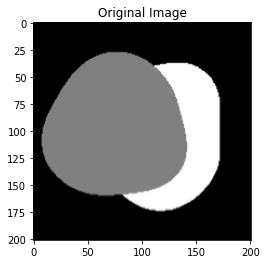

In [4]:
import numpy as np
import cv2


def perlin(x,y,seed=0):
    # permutation table
    #np.random.seed(seed)
    p = np.arange(256,dtype=int)
    np.random.shuffle(p)
    p = np.stack([p,p]).flatten()
    # coordinates of the top-left
    xi = x.astype(int)
    yi = y.astype(int)
    # internal coordinates
    xf = x - xi
    yf = y - yi
    # fade factors
    u = fade(xf)
    v = fade(yf)
    # noise components
    n00 = gradient(p[p[xi]+yi],xf,yf)
    n01 = gradient(p[p[xi]+yi+1],xf,yf-1)
    n11 = gradient(p[p[xi+1]+yi+1],xf-1,yf-1)
    n10 = gradient(p[p[xi+1]+yi],xf-1,yf)
    # combine noises
    x1 = lerp(n00,n10,u)
    x2 = lerp(n01,n11,u) # FIX1: I was using n10 instead of n01
    return lerp(x1,x2,v) # FIX2: I also had to reverse x1 and x2 here

def lerp(a,b,x):
    "linear interpolation"
    return a + x * (b-a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0,1],[0,-1],[1,0],[-1,0]])
    g = vectors[h%4]
    return g[:,:,0] * x + g[:,:,1] * y


def get_curvature(rad):

    rad_t_plus_1  = np.concatenate([rad[1:], rad[:1]], axis=0)
    rad_t_minus_1 = np.concatenate([rad[-1:], rad[:-1]], axis=0)

    drad  = 0.5 * (rad_t_plus_1 - rad_t_minus_1) / (angle[1] - angle[0])
    d2rad = (rad_t_plus_1 - 2 * rad + rad_t_minus_1) / (angle[1] - angle[0]) ** 2

    curvature = np.abs(rad ** 2 + 2 * drad ** 2 - rad * d2rad) / np.sqrt((rad ** 2 + drad ** 2) ** 3)

    return curvature



H = W = 201
maxrad = H / 2.5
minrad = H / 4.0

RF = 21

num_imgs = 1

np.random.seed(2020)
for i in range(num_imgs):

    img_np = np.zeros((H, W), dtype=np.uint8)
    edges = np.zeros((H, W), dtype=np.uint8)
    curvature_img = np.zeros((H, W), dtype=np.float32)
    junctions = np.ones((H, W), dtype=np.bool)

    axis_angle = np.random.rand() * 2 * np.pi

    colors = [255, 128] if np.random.rand() > 0.5 else [128, 255]
    for blob_id, clr in enumerate(colors):
        angle = np.linspace(0.0, 2*np.pi, 10001)[:-1]

        xp = 2.5 + 0.6 * np.cos(angle[np.newaxis, :])
        yp = 2.5 + 0.6 * np.sin(angle[np.newaxis, :])

        p = perlin(xp, yp)

        rad = minrad + (maxrad - minrad) * (0.5 + p)[0, :]

        
        xlist = rad * np.cos(angle) + 0.5 * H + 0.1 * H * np.cos(axis_angle + np.pi * (blob_id == 1))
        ylist = rad * np.sin(angle) + 0.5 * W + 0.1 * W * np.sin(axis_angle + np.pi * (blob_id == 1))

        pts = np.array([[int(x), int(y)] for (x, y) in zip(xlist, ylist)])
        pts = pts.reshape((1, -1, 2))

#         np.save(f'datasets/blobs_small/rad_{blob_id}_{i:03}.npy', rad)
#         np.save(f'datasets/blobs_small/pts_{blob_id}_{i:03}.npy', pts)
        
        
        curr_edges = np.zeros((H, W), dtype=np.uint8)
        cv2.fillPoly(img_np, pts, color=clr, lineType=cv2.LINE_AA)
        cv2.fillPoly(edges, pts, color=(0,))
        cv2.fillPoly(curr_edges, pts, color=(0,))
        cv2.fillPoly(curvature_img, pts, color=(0,))
        
        curvature = get_curvature(rad)
        for t in range(1000):
            clr = curvature[10*t:10*t+10].mean() / 0.02  # Not sure why 0.02, but that's the range
            cv2.polylines(curvature_img, pts[:, 10*t:10*t+10, :], False, (clr,), 1)
            cv2.polylines(curr_edges,    pts[:, 10*t:10*t+10, :], False, (255,), 1)
            cv2.polylines(edges,         pts[:, 10*t:10*t+10, :], False, (255,), 1)
            
        
        junctions &= (curr_edges > 128)


# img_np = cv2.resize(img_np, (55, 55), interpolation=cv2.INTER_AREA)
# edges = cv2.resize(edges, (55, 55), interpolation=cv2.INTER_AREA)
# junctions = cv2.resize(np.uint8(junctions) * 255, (55, 55), interpolation=cv2.INTER_AREA)
# curvature_img = cv2.resize(curvature_img, (55, 55), interpolation=cv2.INTER_AREA)

plt.imshow(img_np,cmap='gray')
img = img_np.reshape(img_np.shape[0],img_np.shape[1],1)
img = np.asarray(img/255.0,dtype=np.float32)
plt.title('Original Image')
Hplt.axis('off');

In [ ]:
H=W=30
img_np = np.zeros((H, W), dtype=np.uint8)

colors = [255, 128] if np.random.rand() > 0.5 else [128, 255]

xlist  = [0,0,int(H/2)]
ylist = [5,H,int(H/2)]
pts = np.array([[int(x), int(y)] for (x, y) in zip(xlist, ylist)])
pts = pts.reshape((1, -1, 2))

#         np.save(f'datasets/blobs_small/rad_{blob_id}_{i:03}.npy', rad)
#         np.save(f'datasets/blobs_small/pts_{blob_id}_{i:03}.npy', pts)

clr=128
cv2.fillPoly(img_np, pts, color=clr, lineType=cv2.LINE_AA)

clr=255
xlist  = [0,H,H]
ylist = [H,H,0]
pts = np.array([[int(x), int(y)] for (x, y) in zip(xlist, ylist)])
pts = pts.reshape((1, -1, 2))
cv2.fillPoly(img_np, pts, color=clr, lineType=cv2.LINE_AA)
img = img_np.reshape(img_np.shape[0],img_np.shape[1],1)
img = np.asarray(img/255.0,dtype=np.float32)
plt.imshow(img_np,cmap='gray')
# plt.axis('off')


In [ ]:
H=W=30
img_np = np.zeros((H, W), dtype=np.uint8)

fr = 8
clr=255
xlist  = [int(H/fr),int(H/fr),int((fr-1)*H/fr),int((fr-1)*H/fr)]
ylist =  [int(H/fr),int((fr-1)*H/fr),int((fr-1)*H/fr),int(H/fr)]
pts = np.array([[int(x), int(y)] for (x, y) in zip(xlist, ylist)])
pts = pts.reshape((1, -1, 2))
cv2.fillPoly(img_np, pts, color=clr)
img = img_np.reshape(img_np.shape[0],img_np.shape[1],1)
img = np.asarray(img/255.0,dtype=np.float32)
plt.imshow(img_np,cmap='gray')


## FoJ on Image

In [ ]:
# Create opts object
opts = SimpleNamespace()

opts.R                        = 21
opts.stride                   = 1
opts.eta                      = 0.01
opts.delta                    = 0.05
opts.lr_angles                = 0.003
opts.lr_x0y0                  = 0.03
opts.lambda_boundary_final    = 0.5
opts.lambda_color_final       = 0.1
opts.nvals                    = 31
opts.num_initialization_iters = 20
opts.num_refinement_iters     = 1000
opts.greedy_step_every_iters  = 50
opts.parallel_mode            = True
opts.ang_per_vertex           = 3


# Define function for optimization (foj.optimize() may be used instead)
def foj_optimize_verbose():
    for i in range(foj.num_iters):
        if i == 0:
            print("Beginning initialization...")
        if i == opts.num_initialization_iters:
            print("Initialization done. Beginning refinement...")
        if i < opts.num_initialization_iters:
            if i % 5 == 0:
                print(f"Initialization iteration {i}/{opts.num_initialization_iters}")
        else:
            if i % 100 == 0:
                print(f"Refinement iteration {i}/{opts.num_refinement_iters}")
        foj.step(i)

# Create and optimize field of junctions
foj = FieldOfJunctions(img, opts)
%time foj_optimize_verbose()       # Run optimization with some printing

# Compute smoothed image and boundary map
params = torch.cat([foj.angles, foj.x0y0], dim=1)
dists, _, patches = foj.get_dists_and_patches(params)
local_boundaries = foj.dists2boundaries(dists)
global_boundaries = foj.local2global(local_boundaries)[0, 0, :, :].detach().cpu().numpy()
smoothed_img = foj.local2global(patches)[0, :, :, :].permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=[12, 12])
plt.subplot(131)
plt.imshow(img)
plt.title('Input')
plt.axis('off')
plt.subplot(132)
plt.imshow(global_boundaries, cmap='gray')
plt.title('Global boundaries')
plt.axis('off')
plt.subplot(133)
plt.imshow(smoothed_img)
plt.title('Smoothed image')
plt.axis('off')

## Sorting patches by wedge angle subtended 

In [ ]:
#Get wedges|
wedges = foj.dists2indicators(dists).detach().cpu().numpy()

#Get numbers of patches
H_patches = wedges.shape[4]
W_patches = wedges.shape[5]
N=1

#Get base angles from horizon
angles = torch.remainder(params[:, :3, :, :], 2 * np.pi)
angles = torch.sort(angles, dim=1)[0].detach().cpu().numpy()

#Slice for horizon angles
t_angle1 = angles[0, 0, :, :]   # shape [N, 1, 1, H', W']
t_angle2 = angles[0, 1, :, :]   # shape [N, 1, 1, H', W']
t_angle3 = angles[0, 2, :, :]  # shape [N, 1, 1, H', W']

#ANGLES ARE SWAPPED BECUASE WEDGES ORDERED COUNTERCLOCKWISE
angle1 = np.remainder(t_angle1-t_angle3,2*np.pi)
angle3 = np.remainder(t_angle2-t_angle1,2*np.pi) 
angle2 = np.remainder(t_angle3-t_angle2,2*np.pi)
anglemat = np.stack((angle1,angle2,angle3),axis = 0)

#Sort and argsort angles
sorted_angles = -1*torch.tensor(np.sort(-anglemat,axis=0))
ang_sort_idx = torch.tensor(np.argsort(-anglemat,axis=0))
# angles_ascending = np.take_along_axis(useful_angles, ang_sort_idx, axis=0)
ang_sort_idx = ang_sort_idx.unsqueeze(-1).swapdims(0,3).squeeze(0)
ang_sort_idx = ang_sort_idx.view(1,1,1,1,H_patches,W_patches,3)
ang_sort_idx = ang_sort_idx.repeat(1,1,opts.R,opts.R,1,1,1)

#Reshape wedges, and patches
wedges = foj.dists2indicators(dists).detach().cpu()
perm_wedges = wedges.unsqueeze(-1).swapdims(1,6)
ang_sorted_wedges_resh = torch.gather(perm_wedges, -1, ang_sort_idx)
ang_sorted_wedges = ang_sorted_wedges_resh.swapdims(1,6).squeeze(-1)

ang_region_patches = ang_sorted_wedges.unsqueeze(1).unsqueeze(3)
ang_permutations = get_permutations(ang_region_patches)

## Creating unary potentials (using logical patch rules)

In [ ]:
#Angle thresholds 
epsilon_0 = .3
epsilon_1 = .1
epsilon_2 = .1

#Threshold for if a vertex is outside the box
out_of_bounds = torch.max(torch.abs(foj.x0y0),axis=1)[0].squeeze(0) 
#Booleans representing the conditionals
w0_pi = torch.abs(sorted_angles[0,...]-np.pi)<epsilon_0
i_w0_pi = torch.abs(sorted_angles[0,...]-np.pi)>epsilon_1
w1_pi = torch.abs(sorted_angles[1,...]-np.pi)<epsilon_1
w2_zero = sorted_angles[2,...]<epsilon_2

unary_pots = np.zeros((6,*w2_zero.cpu().numpy().shape)) 
unary_pots[:,w0_pi.cpu().numpy()& ~w2_zero.cpu().numpy()] = np.array([[1,1,0,0,0,0]]).T
unary_pots[:,w2_zero.cpu().numpy()&~w1_pi.cpu().numpy()] = np.array([[0,0,1,1,0,1]]).T
# unary_pots[:,(~w0_pi.cpu().numpy()& ~w2_zero.cpu().numpy())|(out_of_bounds>1).cpu().numpy()] = np.array([[0,0,0,0,0,0]]).T

## Running Permutation Resolver + Plotting results

In [ ]:
import torch.nn.functional as F
def unary_func(max_iters,t):
    return np.sqrt(max_iters-t)/np.sqrt(max_iters)
def func(x):
    x = -x.abs()
    mult = torch.exp(-30.0 * x.max(0, keepdim=True)[0].max(1, keepdim=True)[0] ** 2)
    return mult* torch.exp(3.0 * x)

# ang_idxs_unary = expanded_resolve_permutations_mrf(ang_permutations, stride=1, Ns=1, max_iters=2000,unary = torch.tensor(0*.0000001*unary_pots), unary_func = unary_func, func=func, func2=func, seed=[50,0])
ang_idxs_unary = local_resolve_permutations_mrf(ang_permutations, stride=3, neighborhood=8, max_iters=2000,unary = torch.tensor(.000001*unary_pots), unary_func = unary_func, func=func, func2=func, seed=[50,0])

In [ ]:
# H = W = 24

ang_perm_tensor_unary = perm_list[ang_idxs_unary].view(1,1,1,1,H_patches,W_patches,3)
ang_perm_tensor_unary = ang_perm_tensor_unary.repeat(1,1,opts.R,opts.R,1,1,1)

ang_perm_wedges_unary = torch.gather(ang_sorted_wedges_resh, -1, ang_perm_tensor_unary)
ang_perm_wedges_unary = ang_perm_wedges_unary.swapdims(1,6).squeeze(6)

wedge_out_unary_1 = reconstruct_img(ang_perm_wedges_unary[0,0,...],H,W,opts.stride,opts.R)
wedge_out_unary_2 = reconstruct_img(ang_perm_wedges_unary[0,1,...],H,W,opts.stride,opts.R)
wedge_out_unary_3 = reconstruct_img(ang_perm_wedges_unary[0,2,...],H,W,opts.stride,opts.R)
plt.figure(figsize=[10,30])
plt.subplot(131)
plt.imshow(wedge_out_unary_1,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 1')
plt.subplot(132)
plt.imshow(wedge_out_unary_2,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 2')
plt.subplot(133)
plt.imshow(wedge_out_unary_3,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 3')
plt.suptitle('Pixelwise layer-certainty estimates with unary potentials')
plt.subplots_adjust(top=1.73);

In [ ]:
ang_idxs_unary.shape

In [ ]:
sorted_angles.shape

In [ ]:
unary_pots.shape

In [ ]:
ang_permutations.shape
unary_input = ang_sorted_wedges.squeeze(0)


In [ ]:
rule1 = w0_pi.cpu().numpy()& ~w2_zero.cpu().numpy() & (out_of_bounds<1).cpu().numpy()
rule2 = w2_zero.cpu().numpy()&~w1_pi.cpu().numpy() & (out_of_bounds<1).cpu().numpy()
rule1[0,0]

In [ ]:
idx = 0
rules_list = []
emptyv = np.zeros(unary_input.shape[3]*unary_input.shape[4]*3)

for i in range(unary_input.shape[3]):
    for j in range(unary_input.shape[4]):
        if rule1[i,j]:
            #First patch is in front of both
            #negative term is in front of  positive term
            update = [-1,0,1]
            rules_list.append(emptyv.copy())
            rules_list[-1][i*unary_input.shape[4]+j:i*unary_input.shape[4]+j+3] = update
            update = [-1,1,0]
            rules_list.append(emptyv.copy())
            rules_list[-1][i*unary_input.shape[4]+j:i*unary_input.shape[4]+j+3] = update
        elif rule2[i,j]:
            update = [1,-1,0]
            rules_list.append(emptyv.copy())
            rules_list[-1][i*unary_input.shape[4]+j:i*unary_input.shape[4]+j+3] = update

In [ ]:
test = np.asarray(rules_list)

In [ ]:
print('test shape', test.shape)
print('nonzero entries', np.count_nonzero(test))

In [ ]:
emptyv.shape

In [ ]:
test.shape

plt.imshow(test)

In [ ]:
# def generate_log_psi_mat(unary_input, stride):
Ns = 1
N_list = np.arange(-Ns,Ns+1)
permutations = ang_permutations
stride = 1
log_psi_mat = torch.zeros(6,6,H_patches,W_patches,Ns*2+1,Ns*2+1)
for i, hs in enumerate(N_list):
    for j, vs in enumerate(N_list):
        if [hs,vs] != [0,0]:
            padarr = [0,0,0,0]
            #This can be simplified somehow for sure 
            if hs>0:
                Px = permutations[:,:,hs*stride:,:,:-hs,:]
                shift_Px = permutations[:,:,:-hs*stride,:,hs:,:]
                padarr[3] = hs
            elif hs == 0:
                Px = permutations
                shift_Px = permutations
                padarr[3] = hs
            else:
                Px = permutations[:,:,:hs*stride,:,-hs:,:] 
                shift_Px = permutations[:,:,-hs*stride:,:,:hs,:]
                padarr[2] = -hs
            if vs>0: 
                Py = Px[:,:,:,vs*stride:,:,:-vs]
                shift_Py = shift_Px[:,:,:,:-vs*stride,:,vs:]
                padarr[1] = vs
            elif vs == 0: 
                Py = Px
                shift_Py = shift_Px
                padarr[1] = vs
            else:
                Py = Px[:,:,:,:vs*stride,:,-vs:] 
                shift_Py = shift_Px[:,:,:,-vs*stride:,:,:vs]
                padarr[0] = -vs

            t1 = func((shift_Py.unsqueeze(2)-Py.unsqueeze(1)).abs().sum(0).mean(2).mean(2));

            log_psi_mat[...,i,j] = F.pad(t1,padarr)
#     return log_psi_mat

In [ ]:
permutations = ang_permutations
stride = 1
log_psi_mat = torch.zeros(6,6,H_patches,W_patches,Ns*2+1,Ns*2+1)
for i, hs in enumerate(N_list):
    for j, vs in enumerate(N_list):
        if [hs,vs] != [0,0]:
            padarr = [0,0,0,0]
            #This can be simplified somehow for sure 

            if hs>0:
                Px = permutations[:,:,hs*stride:,:,:-hs,:]
                shift_Px = permutations[:,:,:-hs*stride,:,hs:,:]
                padarr[3] = hs
            elif hs == 0:
                Px = permutations
                shift_Px = permutations
                padarr[3] = hs
            else:
                Px = permutations[:,:,:hs*stride,:,-hs:,:] 
                shift_Px = permutations[:,:,-hs*stride:,:,:hs,:]
                padarr[2] = -hs
            if vs>0: 
                Py = Px[:,:,:,vs*stride:,:,:-vs]
                shift_Py = shift_Px[:,:,:,:-vs*stride,:,vs:]
                padarr[1] = vs
            elif vs == 0: 
                Py = Px
                shift_Py = shift_Px
                padarr[1] = vs
            else:
                Py = Px[:,:,:,:vs*stride,:,-vs:] 
                shift_Py = shift_Px[:,:,:,-vs*stride:,:,:vs]
                padarr[0] = -vs
            
            t1 = func((shift_Py.unsqueeze(2)-Py.unsqueeze(1)).abs().sum(0).mean(2).mean(2));
            
            log_psi_mat[...,i,j] = F.pad(t1,padarr)


In [ ]:
t1[:,:,0,0]

In [ ]:
log_psi_mat[:,:,0,0,2,1]

In [ ]:
horizontal_logpsi = func((permutations[:, :, :, stride:, :, :-1].unsqueeze(2) -
                          permutations[:, :, :, :-stride, :, 1:].unsqueeze(1)).abs().sum(0).mean(2).mean(2))

# vertical_logpsi[k, l, i, j] is the log psi function between the (i, j) and (i+1, j) patches evaluated at
# the kth and lth permutation respectively.
vertical_logpsi = func((permutations[:, :, stride:, :, :-1, :].unsqueeze(2) -
                        permutations[:, :, :-stride, :, 1:, :].unsqueeze(1)).abs().sum(0).mean(2).mean(2))

# Add padding to avoid having to deal with image boundaries
horizontal_logpsi = torch.nn.functional.pad(horizontal_logpsi, pad=(1, 1, 1, 1))
vertical_logpsi = torch.nn.functional.pad(vertical_logpsi, pad=(1, 1, 1, 1))


# angle45_logpsi[k, l, i, j] is the log psi function between the (i, j) and (i+1, j+1) patches evaluated at
# the kth and lth permutations respectively.
angle45_logpsi = func((permutations[:, :, stride:, stride:, :-1, :-1].unsqueeze(2) -
                        permutations[:, :, :-stride, :-stride, 1:, 1:].unsqueeze(1)).abs().sum(0).mean(2).mean(2))

# angle135_logpsi[k, l, i, j] is the log psi function between the (i, j+1) and (i+1, j) patches evaluated at
# the kth and lth permutations respectively. [Note: This is a shifted version of the match between (i, j) and (i+1, j-1).]
angle135_logpsi = func((permutations[:, :, stride:, :-stride, :-1, 1:].unsqueeze(2) -
                         permutations[:, :, :-stride, stride:, 1:, :-1].unsqueeze(1)).abs().sum(0).mean(2).mean(2))

# Add padding to avoid having to deal with image boundaries
angle45_logpsi = torch.nn.functional.pad(angle45_logpsi, pad=(1, 1, 1, 1))
angle135_logpsi = torch.nn.functional.pad(angle135_logpsi, pad=(1, 1, 1, 1))


In [ ]:
horizontal_logpsi[:,:,1,1]

In [ ]:
log_psi_mat.shape

In [ ]:
log_psi_mat[0,1,:,:,1,2]

In [ ]:
permutations[:, :, :, :-stride, :, 1:].shape

In [ ]:
# Left neighbor:   sum over permutations of the (i, j-1)th patch, i.e. dimension 0
s = (lmbdas.unsqueeze(1)[:, :, 1:-1, :-2] * horizontal_logpsi[:, :, 1:-1, :-1]).sum(dim=0)
# Right neighbor:  sum over permutations of the (i, j+1)th patch, i.e. dimension 1
# s += (lmbdas.unsqueeze(0)[:, :, 1:-1, 2:] * horizontal_logpsi[:, :, 1:-1, 1:]).sum(dim=1)

lmbdas.unsqueeze(1)[:, :, 1:-1, :-2].shape
horizontal_logpsi[:, :, 1:-1, :-1].shape
# (lmbdas.unsqueeze(1)[:, :, 1:-1, :-2] * horizontal_logpsi[:, :, 1:-1, :-1]).shape

In [ ]:
lmbdas_mat = expand_lmbdas(lmbdas,Ns)
s = (lmbdas1.unsqueeze(1)[:, :, 1:-1, :-2] * horizontal_logpsi[:, :, 1:-1, :-1])
s2 = log_psi_mat*lmbdas_mat

In [ ]:
s2[:,:,0,0,2,1]

In [ ]:
s[:,:,1,1]

In [ ]:
log_psi_mat[:,:,0,0,2,1]

In [ ]:
horizontal_logpsi[:,:,1,1]

In [ ]:
t1[:,:,1,0]

In [ ]:
t1 = (horizontal_logpsi[:, :, 1:-1, 1:])

np.linalg.norm(t1-log_psi_mat[:,:,:,:,2,1])

In [ ]:
np.linalg.norm()

In [ ]:
lmbdas1 = torch.ones((6, H_patches+2, W_patches+2), dtype=torch.float32).to(permutations.device) / 6.0
(s.sum(dim=0))[:,1,1]

In [ ]:
(s2.sum(dim=0))[:,0,0,2,1]
s2.shape

In [ ]:
horizontal_logpsi[:, :, 1:-1, :-1].shape

In [ ]:
lmbdas_mat[0,1,1,:,:]

In [ ]:
#Right Shift (for left neighbor?)
plt.imshow(lmbdas1.unsqueeze(1)[:, :, 1:-1, :-2][0,0,:,:])
plt.colorbar()

In [ ]:
hs = 1
vs = 0
padarr = [0,0,0,0]
if vs>0:
    lmbdasx = lmbdas[:,:-vs,:]
    padarr[2] = vs
elif vs == 0:
    lmbdasx = lmbdas
else:
    lmbdasx = lmbdas[:,-vs:,:] 
    padarr[3] = -vs
if hs>0: 
    lmbdasy = lmbdasx[:,:,:-hs]
    padarr[0] = hs
elif hs == 0:
    lmbdasy = lmbdasx
else:
    lmbdasy = lmbdasx[:,:,-hs:] 
    padarr[1] = -hs

In [ ]:
plt.imshow(F.pad(lmbdasy,padarr)[0,...])
plt.colorbar()

In [ ]:
#DOWN
plt.imshow(lmbdas1.unsqueeze(1)[:, :, :-2, 1:-1][0,0,:,:])

In [ ]:
plt.imshow(lmbdas[:, 1:-1, :-2][0,:,:])

In [ ]:
plt.imshow(horizontal_logpsi[:, :, 1:-1, :-1][0,0,:,:])

In [ ]:
plt.imshow(vertical_logpsi[:, :, :-1, 1:-1][0,0,:,:])

In [ ]:
horizontal_logpsi[:, :, 1:-1, :-1].shape

In [ ]:
torch.linalg.norm(vertical_logpsi[:, :, :-1, 1:-1] - t2)

In [ ]:
torch.linalg.norm(horizontal_logpsi[:, :, 1:-1, :-1]- t2)

In [ ]:
torch.linalg.norm(vertical_logpsi[:, :, :-1, 1:-1] - t2)

In [ ]:
#Right Neighbor
plt.imshow(horizontal_logpsi[:, :, 1:-1, 1:][0,0,:,:])
torch.linalg.norm(horizontal_logpsi[:, :, 1:-1, 1:] -  t2)

In [ ]:
plt.imshow(sleft[0,:,:])

In [ ]:
hs = 1
vs = 0
padarr = [0,0,0,0]
if vs>0:
    Px = permutations[:,:,vs*stride:,:,:-vs,:]
    shift_Px = permutations[:,:,:-vs*stride,:,vs:,:]
    padarr[3] = vs
elif vs == 0:
    Px = permutations
    shift_Px = permutations
    padarr[3] = vs
else:
    Px = permutations[:,:,:vs*stride,:,-vs:,:] 
    shift_Px = permutations[:,:,-vs*stride:,:,:vs,:]
    padarr[2] = -vs
if hs>0: 
    Py = Px[:,:,:,hs*stride:,:,:-hs]
    shift_Py = shift_Px[:,:,:,:-hs*stride,:,hs:]
    padarr[0] = hs
elif hs == 0: 
    Py = Px
    shift_Py = shift_Px
    padarr[1] = hs
else:
    Py = Px[:,:,:,:hs*stride,:,-hs:] 
    shift_Py = shift_Px[:,:,:,-hs*stride:,:,:hs]
    padarr[1] = -hs

t1 = func((shift_Py.unsqueeze(1)-Py.unsqueeze(2)).abs().sum(0).mean(2).mean(2));
t2 = F.pad(t1,padarr)

plt.imshow(t2[0,0,...])

In [ ]:
plt.imshow(log_psi_mat[0,0,:,:,2,1])
print(hs,vs)

In [ ]:
plt.imshow(sleft[0,...])
plt.colorbar()

In [ ]:
hs = 1
vs = 0
plt.imshow((log_psi_mat*lmbdas_mat).sum(0)[0,:,:,hs,vs])
plt.colorbar()

In [ ]:
permutations[:,:,vs*stride:,:,:-vs,:].shape

In [ ]:
permutations[:, :, :, stride:, :, :-1].shape

In [ ]:
lmbdas.shape

In [ ]:
def expand_lmbdas(lmbdas,Ns):
    lmbdas_mat = torch.zeros(6,H_patches, W_patches,Ns*2+1,Ns*2+1)
    N_list = np.arange(-Ns,Ns+1)
    for i, hs in enumerate(N_list):
        for j, vs in enumerate(N_list):
            if [vs,hs] is not [0,0]:
                padarr = [0,0,0,0]
                if vs>0:
                    lmbdasx = lmbdas[:,:-vs,:]
                    padarr[2] = vs
                elif vs == 0:
                    lmbdasx = lmbdas
                else:
                    lmbdasx = lmbdas[:,-vs:,:] 
                    padarr[3] = -vs
                if hs>0: 
                    lmbdasy = lmbdasx[:,:,:-hs]
                    padarr[0] = hs
                elif hs == 0:
                    lmbdasy = lmbdasx
                else:
                    lmbdasy = lmbdasx[:,:,-hs:] 
                    padarr[1] = -hs
#                 print(hs,vs,F.pad(lmbdasy,padarr).shape)
                lmbdas_mat[...,i,j] = F.pad(lmbdasy,padarr)
    return lmbdas_mat

In [ ]:
plt.imshow(horizontal_logpsi[:, :, 1:-1, :-1][0,0,:,:])

In [ ]:
plt.imshow((lmbdas1.unsqueeze(1)[:, :, 1:-1, :-2] * horizontal_logpsi[:, :, 1:-1, :-1]).sum(dim=0)[0,...])

In [ ]:
horizontal_logpsi[:, :, 1:-1, 1:]

## Experiments on Left Shift

In [ ]:
plt.subplot(121)
lmbdas_mat = expand_lmbdas(lmbdas,Ns)
plt.imshow(lmbdas1.unsqueeze(1)[:, :, 1:-1, :-2][0,0,...])
plt.title('Orginal left lambda ')
plt.subplot(122)
plt.imshow(lmbdas_mat[0,:,:,2,1])
plt.title('expanded left lambda')

print("Lambda Diff = ", np.linalg.norm(lmbdas1.unsqueeze(1)[:, :, 1:-1, :-2] - lmbdas_mat[...,2,1]))


In [ ]:
for i in range(6):
    for j in range(6):
        print(i,j,"Log_Psi Diff = ", np.linalg.norm(horizontal_logpsi[:, :, 1:-1, :-1][i,j,...] - log_psi_mat[j,i,:,:,2,1]))

In [ ]:
plt.subplot(121)
plt.imshow(horizontal_logpsi[:, :, 1:-1, :-1][0,0,...])
plt.title('Orginal left log_psi ')
plt.subplot(122)
plt.imshow(log_psi_mat[0,0,:,:,2,1])
plt.title('expanded left log_psi')

print("Log_Psi Diff = ", np.linalg.norm(horizontal_logpsi[:, :, 1:-1, :-1] - log_psi_mat[...,2,1]))

In [ ]:
plt.subplot(121)
osv = (lmbdas1.unsqueeze(1)[:, :, 1:-1, :-2] * horizontal_logpsi[:, :, 1:-1, :-1]).sum(dim=0)
plt.imshow(osv[0,...])
# plt.colorbar()
plt.title('Orginal left s_value ')
plt.subplot(122)
esv = (log_psi_mat*lmbdas_mat.unsqueeze(1)).sum(0)
plt.imshow(esv[0,...,2,1])
plt.title('expanded left s_value')
# plt.colorbar()

In [ ]:
print("Difference between original and expanded left s", torch.linalg.norm(osv-esv[...,2,1]))

## Experiments on Right Shift

In [ ]:
plt.subplot(121)
lmbdas_mat = expand_lmbdas(lmbdas,Ns)
plt.imshow(lmbdas1.unsqueeze(0)[:, :, 1:-1, 2:][0,0,...])
plt.title('Orginal right lambda ')
plt.subplot(122)
plt.imshow(lmbdas_mat[0,:,:,0,1])
plt.title('expanded right lambda')

print("Lambda Diff = ", np.linalg.norm(lmbdas1.unsqueeze(0)[:, :, 1:-1, 2:][0,0,...] - lmbdas_mat[0,:,:,0,1]))


In [ ]:
log_psi_mat.shape

In [ ]:
for i in range(6):
    for j in range(6):
#         plt.figure()
#         plt.subplot(121)
#         plt.imshow(horizontal_logpsi[:, :, 1:-1, 1:][i,j,...])
#         plt.title('Orginal right log_psi ')
#         plt.subplot(122)
#         plt.imshow(log_psi_mat[i,j,:,:,0,1])
#         plt.title(f'{i,j} expanded right log_psi')

        print(i,j,"Log_Psi Diff = ", np.linalg.norm(horizontal_logpsi[:, :, 1:-1, 1:][i,j,...] - log_psi_mat[j,i,:,:,0,1]))

In [ ]:
padarr = [0,0,0,0]
if vs>0:
    Px = permutations[:,:,vs*stride:,:,:-vs,:]
    shift_Px = permutations[:,:,:-vs*stride,:,vs:,:]
    padarr[3] = vs
elif vs == 0:
    Px = permutations
    shift_Px = permutations
else:
    Px = permutations[:,:,:vs*stride,:,-vs:,:] 
    shift_Px = permutations[:,:,-vs*stride:,:,:vs,:]
    padarr[2] = -vs
if hs>0: 
    Py =             Px[:,:,:,hs*stride:,:,:-hs]
    shift_Py = shift_Px[:,:,:,:-hs*stride,:,hs:]
    padarr[0] = hs
elif hs == 0: 
    Py = Px
    shift_Py = shift_Px
else:
    Py = Px[:,:,:,:hs*stride,:,-hs:] 
    shift_Py = shift_Px[:,:,:,-hs*stride:,:,:hs]
    padarr[1] = -hs

t1 = func((Py.unsqueeze(2)-shift_Py.unsqueeze(1)).abs().sum(0).mean(2).mean(2));
t2 = F.pad(t1,padarr)

In [ ]:
Py.shape

In [ ]:
hs = 1
vs = 1
Px = permutations[:,:,vs*stride:,:,:-vs,:]
shift_Px = permutations[:,:,:-vs*stride,:,vs:,:]
Py =             Px[:,:,:,:-hs*stride,:,hs:]
shift_Py = shift_Px[:,:,:,hs*stride:,:,:-hs]

plt.subplot(121)
plt.imshow(permutations[:, :, stride:, :-stride, :-1, 1:][0,0,0,0,:,:])
plt.title("Up right shift")
plt.subplot(122)
plt.imshow(Py[0,0,0,0,:,:])
plt.title("Test Shift")

## BL Shift

In [ ]:
for i in range(6):
    for j in range(6):
        plt.figure()
        plt.subplot(121)
        plt.imshow(angle135_logpsi[:, :, 1:, :-1][i,j,...])
        plt.title('Orginal right log_psi ')
        plt.subplot(122)
        plt.imshow(log_psi_mat[i,j,:,:,2,2])
        plt.title(f'{i,j} expanded right log_psi')
        print(i,j,"Log_Psi Diff = ", np.linalg.norm(angle135_logpsi[:, :, 1:, :-1][i,j,...] - log_psi_mat[i,j,:,:,2,2]))

## BR Shift

In [ ]:
angle45_logpsi.shape

In [ ]:
hs = 1
vs = -1

Px = permutations[:,:,-vs*stride:,:,:vs,:]
shift_Px = permutations[:,:,-vs*stride:,:,:vs,:]
Py =             Px[:,:,:,:-hs*stride,:,hs:]
shift_Py = shift_Px[:,:,:,hs*stride:,:,:-hs]

# for i in range(6):
#     for j in range(6):
plt.figure()
plt.subplot(121)
plt.imshow(permutations[:, :, stride:, stride:, :-1, :-1][0,0,0,0,:,:])
plt.title('Orginal right log_psi ')
plt.subplot(122)
plt.imshow(Py[0,0,0,0,:,:])
#         plt.title(f'{i,j} expanded right log_psi')
#         print(i,j,"Log_Psi Diff = ", np.linalg.norm(angle45_logpsi[:, :, 1:, 1:][i,j,...] - log_psi_mat[i,j,:,:,0,2]))

In [ ]:
horizontal_logpsi[:, :, 1:-1, 1:].shape

In [ ]:
plt.subplot(121)
osv = (lmbdas1.unsqueeze(0)[:, :, 1:-1, 2:] * horizontal_logpsi[:, :, 1:-1, 1:]).sum(dim=1)
plt.imshow(osv[0,...])
# plt.colorbar()
plt.title('Orginal Right s_value ')
plt.subplot(122)
esv = (log_psi_mat*lmbdas_mat.unsqueeze(1)).sum(0)
plt.imshow(esv[0,...,0,1])
plt.title('expanded left s_value');

In [ ]:
print("Difference between original and expanded right s", torch.linalg.norm(osv-esv[...,0,1]))

In [ ]:
print("Original lambda shape", lmbdas1.unsqueeze(1)[:, :, 1:-1, :-2].shape)
print("Original logpsi shape", horizontal_logpsi[:, :, 1:-1, :-1].shape)
print("expanded lambda shape", lmbdas_mat[...,2,1].shape)
print("expanded logpsi shape", log_psi_mat[...,2,1].shape)

In [ ]:
log_psi_mat.shape

## Up Shift

In [ ]:
for i in range(6):
    for j in range(6):
        print(i,j,"Log_Psi Diff = ", np.linalg.norm(vertical_logpsi[:, :, :-1, 1:-1][i,j,...] - log_psi_mat[i,j,:,:,1,0]))

## Down Shift

In [ ]:
for i in range(6):
    for j in range(6):
        print(i,j,"Log_Psi Diff = ", np.linalg.norm(vertical_logpsi[:, :, 1:, 1:-1][i,j,...] - log_psi_mat[i,j,:,:,1,2]))

In [ ]:
permutations.shape

In [ ]:
lmbdas_mat = expand_lmbdas(lmbdas,Ns)
plt.imshow((log_psi_mat*lmbdas_mat).sum(0)[0,...,2,1])

In [ ]:
lmbdas_mat.shape

In [ ]:
plt.imshow(lmbdas_mat[0,:,:,2,1])

In [ ]:
plt.imshow((log_psi_mat*lmbdas_mat).sum(0)[0,:,:,2,1])

In [ ]:
plt.imshow(lmbdas1.unsqueeze(1)[:, :, 1:-1, :-2][0,0,:,:])

In [ ]:
def func(x):
    return x

In [ ]:
lmbdas1 = torch.ones((6, H_patches+2, W_patches+2), dtype=torch.float32).to(permutations.device) / 6.0
lmbdas = torch.ones((6, H_patches, W_patches), dtype=torch.float32).to(permutations.device) / 6.0
horizontal_logpsi = func((permutations[:, :, :, stride:, :, :-1].unsqueeze(2) -
                              permutations[:, :, :, :-stride, :, 1:].unsqueeze(1)).abs().sum(0).mean(2).mean(2))

# vertical_logpsi[k, l, i, j] is the log psi function between the (i, j) and (i+1, j) patches evaluated at
# the kth and lth permutation respectively.
vertical_logpsi = func((permutations[:, :, stride:, :, :-1, :].unsqueeze(2) -
                        permutations[:, :, :-stride, :, 1:, :].unsqueeze(1)).abs().sum(0).mean(2).mean(2))

# Add padding to avoid having to deal with image boundaries
horizontal_logpsi = torch.nn.functional.pad(horizontal_logpsi, pad=(1, 1, 1, 1))
vertical_logpsi = torch.nn.functional.pad(vertical_logpsi, pad=(1, 1, 1, 1))

# angle45_logpsi[k, l, i, j] is the log psi function between the (i, j) and (i+1, j+1) patches evaluated at
# the kth and lth permutations respectively.
angle45_logpsi = func((permutations[:, :, stride:, stride:, :-1, :-1].unsqueeze(2) -
                        permutations[:, :, :-stride, :-stride, 1:, 1:].unsqueeze(1)).abs().sum(0).mean(2).mean(
    2))

# angle135_logpsi[k, l, i, j] is the log psi function between the (i, j+1) and (i+1, j) patches evaluated at
# the kth and lth permutations respectively. [Note: This is a shifted version of the match between (i, j) and (i+1, j-1).]
angle135_logpsi = func((permutations[:, :, stride:, :-stride, :-1, 1:].unsqueeze(2) -
                         permutations[:, :, :-stride, stride:, 1:, :-1].unsqueeze(1)).abs().sum(0).mean(2).mean(
    2))

# Add padding to avoid having to deal with image boundaries
angle45_logpsi = torch.nn.functional.pad(angle45_logpsi, pad=(1, 1, 1, 1))
angle135_logpsi = torch.nn.functional.pad(angle135_logpsi, pad=(1, 1, 1, 1))


log_psi_mat = torch.zeros(6,6,H_patches,W_patches,Ns*2+1,Ns*2+1)
for i, hs in enumerate(N_list):
    for j, vs in enumerate(N_list):
        if [hs,vs] != [0,0]:
            padarr = [0,0,0,0]
            if vs>0:
                Px = permutations[:,:,:-vs*stride,:,vs:,:]
                shift_Px = permutations[:,:,vs*stride:,:,:-vs,:]
                padarr[3] = vs
            elif vs == 0:
                Px = permutations
                shift_Px = permutations
                padarr[3] = vs
            else:
                Px = permutations[:,:,:vs*stride,:,-vs:,:]
                shift_Px = permutations[:,:,-vs*stride:,:,:vs,:] 
                padarr[2] = -vs
            if hs>0: 
                Py =             Px[:,:,:,:-hs*stride,:,hs:]
                shift_Py = shift_Px[:,:,:,hs*stride:,:,:-hs]
                padarr[0] = hs
            elif hs == 0: 
                Py = Px
                shift_Py = shift_Px
                padarr[1] = hs
            else:
                Py = Px[:,:,:,:hs*stride,:,-hs:] 
                shift_Py = shift_Px[:,:,:,-hs*stride:,:,:hs]
                padarr[1] = -hs

            t1 = func((-Py.unsqueeze(1)+shift_Py.unsqueeze(2)).abs().sum(0).mean(2).mean(2));
            t2 = F.pad(t1,padarr)

#             t1 = func((shift_Py.unsqueeze(2)-Py.unsqueeze(1)).abs().sum(0).mean(2).mean(2));
            
            log_psi_mat[...,i,j] = F.pad(t1,padarr)

            
            
# Set all distributions to uniform except seed which is set to [1, 0, 0, 0, 0, 0].
lmbdas1 = torch.zeros((6, H_patches + 2, W_patches + 2), dtype=torch.float32).to(permutations.device) / 6.0

for t in range(100):
    lmbdas = torch.rand(lmbdas1[:, 1:-1, 1:-1].shape)
    lmbdas /= lmbdas.sum(dim=0, keepdim=True)
    lmbdas1[:, 1:-1, 1:-1] = lmbdas
#     lmbdas1 /= lmbdas1.sum(dim=0, keepdim=True)
    
    # Left neighbor:   sum over permutations of the (i, j-1)th patch, i.e. dimension 0
    sleft = (lmbdas1.unsqueeze(1)[:, :, 1:-1, :-2] * horizontal_logpsi[:, :, 1:-1, :-1]).sum(dim=0)
    s= sleft
    # Right neighbor:  sum over permutations of the (i, j+1)th patch, i.e. dimension 1
    sright = (lmbdas1.unsqueeze(0)[:, :, 1:-1, 2:] * horizontal_logpsi[:, :, 1:-1, 1:]).sum(dim=1)
    s+=sright
    # Top neighbor:    sum over permutations of the (i-1, j)th patch, i.e. dimension 0
    stop = (lmbdas1.unsqueeze(1)[:, :, :-2, 1:-1] * vertical_logpsi[:, :, :-1, 1:-1]).sum(dim=0)
    s+=stop
    # Bottom neighbor: sum over permutations of the (i+1, j)th patch, i.e. dimension 1
    sbot = (lmbdas1.unsqueeze(0)[:, :, 2:, 1:-1] * vertical_logpsi[:, :, 1:, 1:-1]).sum(dim=1)
    s+=sbot

    # TL neighbor: sum over permutations of the (i-1, j-1)th patch, i.e. dimension 0
    stl = (lmbdas1.unsqueeze(1)[:, :, :-2, :-2] * angle45_logpsi[:, :, :-1, :-1]).sum(dim=0)
    s+=stl
    # BR neighbor: sum over permutations of the (i+1, j+1)th patch, i.e. dimension 1
    sbr = (lmbdas1.unsqueeze(0)[:, :, 2:, 2:] * angle45_logpsi[:, :, 1:, 1:]).sum(dim=1)
    s+=sbr
    # TR neighbor: sum over permutations of the (i-1, j+1)th patch, i.e. dimension 0
    stopr = (lmbdas1.unsqueeze(1)[:, :, :-2, 2:] * angle135_logpsi[:, :, :-1, 1:]).sum(dim=0)
    s+=stopr
    # BL neighbor: sum over permutations of the (i+1, j-1)th patch, i.e. dimension 1
    sbl = (lmbdas1.unsqueeze(0)[:, :, 2:, :-2] * angle135_logpsi[:, :, 1:, :-1]).sum(dim=1)
    s+=sbl

    # Update parameters according to CAVI update
    lmbdas1[:, 1:-1, 1:-1] = torch.exp(s)


    # Normalize and reset top-left distribution
#     lmbdas1 /= lmbdas1.sum(dim=0, keepdim=True)
    lmbdas1[:, 1:-1, 1:-1] /= lmbdas1[:, 1:-1, 1:-1].sum(dim=0, keepdim=True)
    
    lmbdas_mat = expand_lmbdas(lmbdas,Ns)
    s2 = (log_psi_mat*lmbdas_mat.unsqueeze(1)).sum(0).sum(3).sum(3)
    lmbdas = torch.exp(s2)
    lmbdas /= lmbdas.sum(dim=0,keepdim=True)
    

    if (t%1 == 0):
        print('iter:',t,'diff:', torch.linalg.norm(s-s2))
        print('norm s: ', torch.linalg.norm(s), 'norm s2: ', torch.linalg.norm(s2))
        print('Second diff', torch.linalg.norm(lmbdas1[:, 1:-1, 1:-1] - lmbdas))

    #Random test
    lmbdas1[:, 1:-1, 1:-1] = lmbdas
    sleft = (lmbdas1.unsqueeze(1)[:, :, 1:-1, :-2] * horizontal_logpsi[:, :, 1:-1, :-1]).sum(dim=0)
    sright = (lmbdas1.unsqueeze(0)[:, :, 1:-1, 2:] * horizontal_logpsi[:, :, 1:-1, 1:]).sum(dim=1)

In [ ]:
s2.shape

In [ ]:
# sleft = (lmbdas1.unsqueeze(0)[:, :, 1:-1, 2:] * horizontal_logpsi[:, :, 1:-1, 1:]).sum(dim=1)
# sright[:,0,0]+stopr[:,0,0]+sbr[:,0,0]
# sbot[:,0,0]+stop[:,0,0]
sleft[:,0,0]+sl

In [ ]:
(s2.sum(dim=0).sum(dim=3).sum(dim=3))[:,0,0,...]

In [ ]:
out1[:,2,2]

In [ ]:
s2 = log_psi_mat*lmbdas_mat
out2 = s2.sum(0).sum(3).sum(3)
out2[:,2,2]

In [ ]:
torch.norm(out1-out2,1)

In [ ]:
(lmbdas1.unsqueeze(0)[:, :, 1:-1, 2:] * horizontal_logpsi[:, :, 1:-1, 1:]).shape

## Experiments on wedge overlap

In [ ]:
permutations = ang_permutations
no_perms = permutations[:,0,...]
Ns = 3
N_list = np.arange(-Ns,Ns+1)
stride = opts.stride
log_psi_mat = torch.zeros(3,3,H_patches,W_patches,Ns*2+1,Ns*2+1)
for i, hs in enumerate(N_list):
    for j, vs in enumerate(N_list):
        if [hs,vs] != [0,0]:
            padarr = [0,0,0,0]
            if vs>0:
                Px = no_perms[:,vs*stride:,:,:-vs,:]
                shift_Px = no_perms[:,:-vs*stride,:,vs:,:]
                padarr[3] = vs
            elif vs == 0:
                Px = no_perms
                shift_Px = no_perms
                padarr[3] = vs
            else:
                Px = no_perms[:,:vs*stride,:,-vs:,:] 
                shift_Px = no_perms[:,-vs*stride:,:,:vs,:]
                padarr[2] = -vs
            if hs>0: 
                Py = Px[:,:,hs*stride:,:,:-hs]
                shift_Py = shift_Px[:,:,:-hs*stride,:,hs:]
                padarr[0] = hs
            elif hs == 0: 
                Py = Px
                shift_Py = shift_Px
                padarr[1] = hs
            else:
                Py = Px[:,:,:hs*stride,:,-hs:] 
                shift_Py = shift_Px[:,:,-hs*stride:,:,:hs]
                padarr[1] = -hs
            #Average over the the truncated patch
#             t1 = func((Py.unsqueeze(1)-shift_Py.unsqueeze(0)).abs().mean(2).mean(2));
            #Sum over the truncated patch
            t1 = torch.multiply(Py.unsqueeze(1),shift_Py.unsqueeze(0)).abs().sum(2).sum(2);
            t2 = F.pad(t1,padarr)

#             t1 = func((shift_Py.unsqueeze(2)-Py.unsqueeze(1)).abs().sum(0).mean(2).mean(2));
            
            log_psi_mat[...,i,j] = F.pad(t1,padarr)

In [ ]:
(Py.unsqueeze(1)-shift_Py.unsqueeze(0)).shape

In [ ]:
i,j = [15,4]
plt.subplot(131)
# plt.title(f'Depth {output[i,j,0]:.2f}')
plt.imshow(ang_sorted_wedges[0,0,:,:,i,j],vmin=0,vmax=1)
plt.subplot(132)

# plt.title(f'Depth {output[i,j,1]:.2f}')
plt.imshow(ang_sorted_wedges[0,1,:,:,i,j],vmin=0,vmax=1)
plt.subplot(133)
# plt.title(f'Depth {output[i,j,2]:.2f}')
plt.imshow(ang_sorted_wedges[0,2,:,:,i,j],vmin=0,vmax=1)

i,j = [14,5]
plt.figure()
plt.subplot(131)
# plt.title(f'Depth {output[i,j,0]:.2f}')
plt.imshow(ang_sorted_wedges[0,0,:,:,i,j],vmin=0,vmax=1)
plt.subplot(132)

# plt.title(f'Depth {output[i,j,1]:.2f}')
plt.imshow(ang_sorted_wedges[0,1,:,:,i,j],vmin=0,vmax=1)
plt.subplot(133)
# plt.title(f'Depth {output[i,j,2]:.2f}')
plt.imshow(ang_sorted_wedges[0,2,:,:,i,j],vmin=0,vmax=1)


In [ ]:
#upper neighboring
print(log_psi_mat[0,2,5,5,1,0])
print(log_psi_mat[2,0,4,5,1,2])

#Right neighboring
print(log_psi_mat[0,2,5,5,0,1])
print(log_psi_mat[2,0,5,6,2,1])

In [ ]:
rule1 = w0_pi.cpu().numpy()& ~w2_zero.cpu().numpy() & (out_of_bounds<1).cpu().numpy()
rule2 = w2_zero.cpu().numpy()&~w1_pi.cpu().numpy() & (out_of_bounds<1).cpu().numpy()
rule1[0,0]

In [ ]:
plt.imshow(rule1)

In [ ]:
idx = 0
rules_list = []
unary_input = ang_sorted_wedges.squeeze(0)

emptyv = np.zeros(unary_input.shape[3]*unary_input.shape[4]*3)

for i in range(unary_input.shape[3]):
    for j in range(unary_input.shape[4]):
        if rule1[i,j]:
            #First patch is in front of both
            #negative term is in front of  positive term
            update = [-1,0,1]
            rules_list.append(emptyv.copy())
            rules_list[-1][(i*unary_input.shape[4]+j)*3:(i*unary_input.shape[4]+(j+1))*3] = update
            update = [-1,1,0]
            rules_list.append(emptyv.copy())
            rules_list[-1][(i*unary_input.shape[4]+j)*3:(i*unary_input.shape[4]+(j+1))*3] = update
        elif rule2[i,j]:
            update = [1,-1,0]
            rules_list.append(emptyv.copy())
            rules_list[-1][(i*unary_input.shape[4]+j)*3:(i*unary_input.shape[4]+(j+1))*3] = update

rules_mat = np.asarray(rules_list)

In [ ]:
#                         ## Upper neighbor?
#                         ov = log_psi_mat[neighbor,wedge,i,j,1+n_i,1+n_j]
#                         ov_list.append(emptyv.copy())
#                         ov_list[-1][3*(i*unary_input.shape[4]+j)+wedge] = np.sqrt(ov)
#                         ov_list[-1][3*((i+n_j)*unary_input.shape[4]+j-n_i)+neighbor] = - np.sqrt(ov)
#                         ## Lower neighbor?
#                         ov = log_psi_mat[neighbor,wedge,i,j,1,2]
#                         ov_list.append(emptyv.copy())
#                         ov_list[-1][3*(i*unary_input.shape[4]+j)+wedge] = np.sqrt(ov)
#                         ov_list[-1][3*((i+1)*unary_input.shape[4]+j)+neighbor] = - np.sqrt(ov)
#                         ## Right neighbor?
#                         ov = log_psi_mat[neighbor,wedge,i,j,0,1]
#                         ov_list.append(emptyv.copy())
#                         ov_list[-1][3*(i*unary_input.shape[4]+j)+wedge] = np.sqrt(ov)
#                         ov_list[-1][3*(i*unary_input.shape[4]+j-n_i)+neighbor] = - np.sqrt(ov)
#                         ## Left neighbor?
#                         ov = log_psi_mat[neighbor,wedge,i,j,2,1]
#                         ov_list.append(emptyv.copy())
#                         ov_list[-1][3*(i*unary_input.shape[4]+j)+wedge] = np.sqrt(ov)
#                         ov_list[-1][3*(i*unary_input.shape[4]+j-1)+neighbor] = - np.sqrt(ov)


In [ ]:
emptyv = np.zeros(unary_input.shape[3]*unary_input.shape[4]*3)
# ov_list = np.zeros(unary_input.shape[3]*unary_input.shape[4]*3, unary_input.shape[3]*unary_input.shape[4]*3)
ov_list = []
Ns = 3
n_list = np.arange(-Ns,Ns+1)
for neighbor in range(3):
    for wedge in range(3):
        for n_i in n_list:
            for n_j in n_list:
                for i in range(max(0, -n_j),
                               min(unary_input.shape[4]+n_j,unary_input.shape[4])):
                    for j in range(max(0,-n_i),
                                    min(unary_input.shape[3]+n_i,unary_input.shape[3])):
                        ## Upper neighbor?
                        ov = log_psi_mat[neighbor,wedge,i,j,Ns+n_i,Ns+n_j]
                        ov_list.append(emptyv.copy())
                        ov_list[-1][3*(i*unary_input.shape[4]+j)+wedge] = np.sqrt(ov)
                        ov_list[-1][3*((i-n_j)*unary_input.shape[4]+j-n_i)+neighbor] = - np.sqrt(ov)
t1 = np.asarray(ov_list)

In [ ]:
log_psi_mat.shape

In [ ]:
t1.shape

In [ ]:
neighbor = 0
wedge = 0

log_psi_mat[neighbor,wedge,i,j,...]

## An attempt to use torch autograd

In [ ]:
import torch
from torch.nn import functional as F
import torch.nn as nn

In [ ]:
selector = torch.ones(M.shape[0])/2
# torch.multiply(torch.bernoulli(selector),M.T)
torch.count_nonzero(M.T)
torch.count_nonzero(torch.multiply(torch.bernoulli(selector),M.T))

In [ ]:
#Unary term
A = torch.tensor(rules_mat,dtype =torch.float32)

#Overlap term
M= torch.tensor(t1,dtype =torch.float32)

#Random Selection term
TRUNC = True
trunc_frac = 1/5
selector = torch.ones(M.shape[0])*trunc_frac


#Possible exponentiation?
M6 = torch.pow(M.T@M,3)
b = 2
x = torch.rand((t1.shape[1],1),dtype =torch.float32,requires_grad = True)

pairwise_penalty = 1e-6
def forward():
    u_term = torch.norm(F.relu(-A@x +b),p=1)
    if TRUNC:
        Mstar = torch.multiply(torch.bernoulli(selector),M.T).T
    else:
        Mstar = M
    pair_term = x.T@Mstar.T@Mstar@x
    return u_term+pair_term*pairwise_penalty

def loss(err):
    return err.mean()

# class DepthRegressor(nn.module):
#     def __init__(self):
#         super(DepthRegressor,self).__init__()
#     def forward


In [ ]:
lr = .1
niter = 200

optimizer = torch.optim.Adam([x],lr = lr)
for epoch in range(niter):
    err = forward()
    l = loss(err)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 10 == 0:
        print(f'epoch {epoch+1}, loss = {l.item():.8f}')

In [ ]:
output = x.detach().numpy()
output = output.reshape([unary_input.shape[3],unary_input.shape[4],3])
ang_sorted_wedges.shape
permute_sort_wedges = ang_sorted_wedges[0,...].movedim(0,-1)
permute_sort_wedges.shape

In [ ]:
output.shape

In [ ]:
ang_sorted_wedges.shape
permute_sort_wedges = ang_sorted_wedges[0,...].movedim(0,-1)
permute_sort_wedges.shape

In [ ]:
#Get depth measurements
depths = torch.multiply(permute_sort_wedges,torch.tensor(output))
depths = depths.sum(-1)

In [ ]:
depth_map = reconstruct_img(depths,H,W,opts.stride,opts.R)

plt.imshow(depth_map)
plt.colorbar()
plt.title('Depth mapping for combined potential')
plt.axis('off')

In [ ]:
wedge_out_unary_1 = reconstruct_img(ang_sorted_wedges[0,0,...],H,W,opts.stride,opts.R)
wedge_out_unary_2 = reconstruct_img(ang_sorted_wedges[0,1,...],H,W,opts.stride,opts.R)
wedge_out_unary_3 = reconstruct_img(ang_sorted_wedges[0,2,...],H,W,opts.stride,opts.R)
plt.figure(figsize=[10,30])
plt.subplot(131)
plt.imshow(wedge_out_unary_1,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 1')
plt.subplot(132)
plt.imshow(wedge_out_unary_2,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 2')
plt.subplot(133)
plt.imshow(wedge_out_unary_3,vmin=0,vmax=1)
# plt.colorbar()
plt.axis('off')
plt.title('Layer 3')
plt.suptitle('Pixelwise layer-certainty estimates with unary potentials')
plt.subplots_adjust(top=1.73);

In [ ]:

i,j = [15,4]
plt.subplot(131)
plt.title(f'Depth {output[i,j,0]:.2f}')
plt.imshow(ang_sorted_wedges[0,0,:,:,i,j] * output[i,j,0],vmin=0,vmax=1)
plt.subplot(132)

plt.title(f'Depth {output[i,j,1]:.2f}')
plt.imshow(ang_sorted_wedges[0,1,:,:,i,j]* output[i,j,1],vmin=0,vmax=1)
plt.subplot(133)
plt.title(f'Depth {output[i,j,2]:.2f}')
plt.imshow(ang_sorted_wedges[0,2,:,:,i,j]* output[i,j,2],vmin=0,vmax=1)

plt.figure()
i,j = [14,5]
plt.subplot(131)
plt.title(f'Depth {output[i,j,0]:.2f}')
plt.imshow(ang_sorted_wedges[0,0,:,:,i,j] * output[i,j,0],vmin=0,vmax=1)
plt.subplot(132)

plt.title(f'Depth {output[i,j,1]:.2f}')
plt.imshow(ang_sorted_wedges[0,1,:,:,i,j]* output[i,j,1],vmin=0,vmax=1)
plt.subplot(133)
plt.title(f'Depth {output[i,j,2]:.2f}')
plt.imshow(ang_sorted_wedges[0,2,:,:,i,j]* output[i,j,2],vmin=0,vmax=1)

In [ ]:
log_psi_mat.shape

In [ ]:
plt.imshow(log_psi_mat[:,:,15,4,0,0])
plt.colorbar()